In [6]:
#!pip install dm-sonnet
#!pip install tensorflow-probability-gpu
#!pip install wrapt
# Uncomment for installation on GPUs

  Running setup.py bdist_wheel for wrapt ... done
  Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built wrapt
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
from __future__ import print_function

%matplotlib notebook


import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sonnet as snt

from tensorflow.keras import datasets

In [8]:
def get_fashion_MNIST_data():
    """Download the Fashion MNIST dataset."""
    
    train_data, test_data = datasets.fashion_mnist.load_data()
    
    train_data_mean = np.mean(train_data[0])
    train_data_stdev = np.std(train_data[0])
    train_data = ((train_data[0] - train_data_mean) /
                  train_data_stdev, train_data[1])
    test_data = ((test_data[0] - train_data_mean) /
                 train_data_stdev, test_data[1])

    return train_data, test_data

def print_data_info():
    """ Print Information on the Fashion MNIST dataset. """

    train_data, test_data = get_fashion_MNIST_data()

    # Split dataset into images and labels
    train_images, train_labels = train_data
    test_images, test_labels = test_data
    # Class names (needed only for illustration purposes)
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                   'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Display information about the dataset
    print("Training Data ::: Images Shape: {}, Labels Shape: {}".format(
        train_images.shape, train_labels.shape))
    print("Test Data ::: Images Shape: {}, Labels Shape: {}".format(
        test_images.shape, test_labels.shape))
    print("Random 25 Images from the Training Data:")
    plt.figure(figsize=(10, 10))
    for i in range(25):
        rand_image_idx = np.random.randint(0, train_labels.shape[0])
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[rand_image_idx], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[rand_image_idx]])
    plt.show()

4431872/4422102 [==============================] - 3s 1us/step
Training Data ::: Images Shape: (60000, 28, 28), Labels Shape: (60000,)
Test Data ::: Images Shape: (10000, 28, 28), Labels Shape: (10000,)
Random 25 Images from the Training Data:


<IPython.core.display.Javascript object>


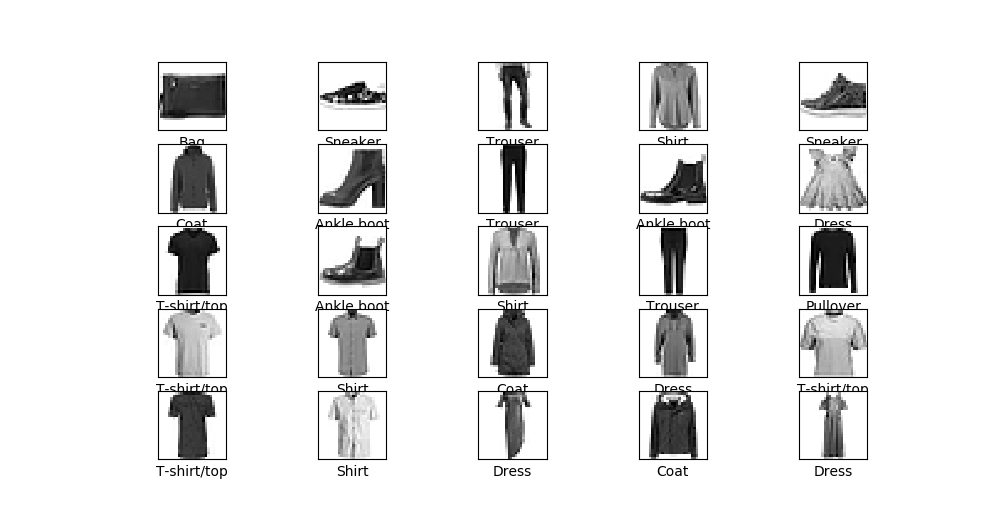

In [9]:
print_data_info()

In [22]:
class FMNISTMLPClassifier(snt.AbstractModule):
    def __init__(self, name='fmnist_mlp_classfier'):
        #super().__init__(name=name)
        snt.AbstractModule.__init__(self, name=name)
        
    def _build(self, inputs):
        outputs = snt.BatchFlatten()(inputs)
        outputs = snt.nets.MLP(
            output_sizes=[128, 10],
            name='fmnist_mlp'
        )(outputs)
        
        return outputs

In [23]:
def train(batch_size=1000, epoch=5):
    train_data, test_data = get_fashion_MNIST_data()
    
    train_images, train_labels = train_data
    test_images, test_labels = test_data
    
    
    tf.reset_default_graph()
    
    train_images_op = tf.placeholder(
        shape=train_images.shape, dtype=tf.float32, name="train_images_ph")
    train_labels_op = tf.placeholder(
        shape=train_labels.shape, dtype=tf.int64, name='train_labels_ph')
    
    test_images_op = tf.placeholder(
        shape=test_images.shape, dtype=tf.float32, name='test_images_ph')
    test_labels_op = tf.placeholder(
        shape=test_labels.shape, dtype=tf.int64, name='test_labels_ph')
    
    batch_size_op = tf.placeholder(dtype=tf.int64)
    
    train_dataset_op = tf.data.Dataset.from_tensor_slices(
        (train_images_op, train_labels_op))
    train_dataset_op = train_dataset_op.shuffle(buffer_size=10000)
    train_dataset_op = train_dataset_op.batch(batch_size_op)

    test_dataset_op = tf.data.Dataset.from_tensor_slices(
        (test_images_op, test_labels_op))
    test_dataset_op = test_dataset_op.shuffle(buffer_size=10000)
    test_dataset_op = test_dataset_op.batch(batch_size_op)

    """ Create a reinitializable iterator. This type of iterator can be 
        initialized with any dataset that contains records with similar type 
        and shape. Since the records in the training and test datasets share 
        similar type and shape we can use this iterator to swap them.
    """
    iterator_op = tf.data.Iterator.from_structure(
        train_dataset_op.output_types,
        train_dataset_op.output_shapes)
    next_batch_images_op, next_batch_labels_op = iterator_op.get_next()

    training_init_op = iterator_op.make_initializer(train_dataset_op)
    testing_init_op = iterator_op.make_initializer(test_dataset_op)
    
    model = FMNISTMLPClassifier()
    
    # Step 4: Setup the training apparatus
    prediction_op = model(next_batch_images_op)  # Forward pass Op
    loss_op = tf.losses.sparse_softmax_cross_entropy(
        next_batch_labels_op, prediction_op)  # Loss Op
    optimizer = tf.train.AdamOptimizer()  # Optimizer Op
    sgd_step = optimizer.minimize(loss_op)  # Gradient Descent step Op.

    """ Op to evaluate training and test accuracy every epoch. 
        `tf.metrics.accuracy` returns two ops: `acc_op` and `acc_update_op`. 
        `acc_op` performs the calculation to give the current accuracy based on 
        the current counts. `acc_update_op` performs the evaluations and updates 
        the counts needed to calculate accuracy.
    """
    acc_op, acc_update_op = tf.metrics.accuracy(
        labels=next_batch_labels_op,
        predictions=tf.argmax(prediction_op, 1),
        name='accuracy_metric'
    )

    """ Since we want to evaluate both test and training accuracy we need to 
        make sure that the count variables in the accuracy op is reset after 
        each evaluation. In order to do that we need to create an initializer 
        just for the variables associated with the accuracy op. When this 
        initializer is called after (or before) every evaluation we can ensure 
        that the count variables are reset.
    """
    # Get initializer for accuracy vars to reset them after each epoch.
    accuracy_running_vars = tf.get_collection(
        tf.GraphKeys.LOCAL_VARIABLES, scope="accuracy_metric")
    accuracy_vars_initializer = tf.variables_initializer(
        var_list=accuracy_running_vars)

    # Pre-defined Feed dicts to sent data to placeholders.
    train_feed_dict = {train_images_op: train_images,
                       train_labels_op: train_labels, batch_size_op: batch_size}
    train_eval_feed_dict = {train_images_op: train_images,
                            train_labels_op: train_labels,
                            batch_size_op: len(train_labels)}
    test_feed_dict = {test_images_op: test_images,
                      test_labels_op: test_labels,
                      batch_size_op: len(test_labels)}

    # Step 5: Train
    with tf.Session() as sess:
        # Initialize local and global variables
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())

        # Epochs
        for idx in range(epoch):
            start = time.time()  # Taking time to track training duration for epoch

            # Initialize accuracy count variable for evaluating training accuracy
            sess.run(accuracy_vars_initializer)

            # Initialize the dataset iterator with the training dataset.
            sess.run(training_init_op, feed_dict=train_feed_dict)

            # Loop until the SGD is performed over the entire dataset.
            while True:
                try:
                    # After an SGD step perform training accuracy evaluation for the current batch
                    sess.run([sgd_step, acc_update_op],
                             feed_dict=train_feed_dict)
                except tf.errors.OutOfRangeError:  # No more data in the input pipeline
                    break
            # Calculate training time for epoch.
            train_time = time.time()-start

            print("Epoch {:d} ::: Training Time: {:.2f}s,".format(
                idx+1, train_time), end=' ')

            # Evaluate the training loss with the current model
            sess.run(training_init_op, feed_dict=train_eval_feed_dict)
            print("Training Loss: {:.5f},".format(
                sess.run(loss_op, feed_dict=train_eval_feed_dict)), end=' ')

            print("Training Accuracy: {:.5f},".format(
                sess.run(acc_op)), end=' ')

            # Initialize accuracy count variable for evaluating test accuracy
            sess.run(accuracy_vars_initializer)

            # Initialize the dataset iterator with the test dataset.
            sess.run(testing_init_op, feed_dict=test_feed_dict)

            # Perform accuracy evaluation for the entire test dataset in one go.
            sess.run(acc_update_op, feed_dict=test_feed_dict)
            print("Test Accuracy: {:.5f}".format(sess.run(acc_op)))

In [15]:
train(batch_size=256, epoch=10) #Using CPU

Epoch 1 ::: Training Time: 22.64s, Training Loss: 0.40109, Training Accuracy: 0.81643, Test Accuracy: 0.84610
Epoch 2 ::: Training Time: 22.81s, Training Loss: 0.34777, Training Accuracy: 0.86313, Test Accuracy: 0.85780
Epoch 3 ::: Training Time: 23.52s, Training Loss: 0.31021, Training Accuracy: 0.87630, Test Accuracy: 0.86830
Epoch 4 ::: Training Time: 23.22s, Training Loss: 0.29053, Training Accuracy: 0.88467, Test Accuracy: 0.87180
Epoch 5 ::: Training Time: 23.82s, Training Loss: 0.28258, Training Accuracy: 0.89177, Test Accuracy: 0.86980
Epoch 6 ::: Training Time: 23.49s, Training Loss: 0.25717, Training Accuracy: 0.89667, Test Accuracy: 0.87620
Epoch 7 ::: Training Time: 23.39s, Training Loss: 0.24385, Training Accuracy: 0.90285, Test Accuracy: 0.87880
Epoch 8 ::: Training Time: 23.42s, Training Loss: 0.24156, Training Accuracy: 0.90537, Test Accuracy: 0.87880
Epoch 9 ::: Training Time: 23.49s, Training Loss: 0.23498, Training Accuracy: 0.90952, Test Accuracy: 0.87540
Epoch 10 :

In [24]:
train(batch_size=256, epoch=10) #Using GPU

Epoch 1 ::: Training Time: 51.71s, Training Loss: 0.40528, Training Accuracy: 0.81765, Test Accuracy: 0.84110
Epoch 2 ::: Training Time: 50.72s, Training Loss: 0.34582, Training Accuracy: 0.86383, Test Accuracy: 0.85630
Epoch 3 ::: Training Time: 52.17s, Training Loss: 0.31115, Training Accuracy: 0.87747, Test Accuracy: 0.86530
Epoch 4 ::: Training Time: 51.30s, Training Loss: 0.30378, Training Accuracy: 0.88518, Test Accuracy: 0.86230
Epoch 5 ::: Training Time: 51.23s, Training Loss: 0.27615, Training Accuracy: 0.89370, Test Accuracy: 0.87320
Epoch 6 ::: Training Time: 51.41s, Training Loss: 0.26116, Training Accuracy: 0.89775, Test Accuracy: 0.87450
Epoch 7 ::: Training Time: 54.28s, Training Loss: 0.25967, Training Accuracy: 0.90322, Test Accuracy: 0.86990
Epoch 8 ::: Training Time: 54.11s, Training Loss: 0.24388, Training Accuracy: 0.90662, Test Accuracy: 0.87480
Epoch 9 ::: Training Time: 53.09s, Training Loss: 0.23347, Training Accuracy: 0.91023, Test Accuracy: 0.87510
Epoch 10 :